# Regime Classification: Long-Term US Bonds
This notebook explores the application of machine learning to predict long-term bond regimes. First, the machine learning model used is the random forest classifier. This model builds multiple decision trees and aggregates individual predictions into a single classification. It uses ***bagging*** and ***bootstrapping*** to ensure trees are uncorrelated, making the model robust and less prone to overfitting. Secondly, a ***regime*** is defined as a period of distinct market conditions. I use a bull regime to denote a period of positive returns and a bear regime to denote a period of negative returns. The distinction of regimes comes from the historical return distribution's quantiles.<br>
The notebook is structured as follows:
1. Theoretical Justification (hypothesis)
2. Bond Market Returns Exploration
3. Finding Features
4. Model Training
5. Model Performance
6. Model Validation
7. Strategy Overview
8. Backtesting
9. Conclusion and Viability

I also explore the predictability of mid-term US bond markets (10-20 years) using similar factors.

## 1. Theoretical Justification
Long-term US (treasury) bonds are debt instruments issued by the US government. Upon issuance, the governemnt offers periodic coupon payments along with the repayment of principal upon expiration. While US bonds are considered "risk-free" in principal, they are not "risk-free" in price. Bond prices are affected by a multitude of factors (expected growth, expected inflation, US government credit ratings, ect. just to name a few). Becasue US bonds are risky in price and exhibit long-term trends, there exists an opportunity to predict its regimes using factors that drive interest rates (thus price). Bond markets exhibit macro trends due to business and interest rate cycles. Using these common factors, I beleive that machine learning models can capture the relationship between long-term bond prices and these macro and technical features. Even with a slight prediction edge (over 50% accuracy), prediction models can harvest returns greater than the general market index. TLT (20+ year US treasury ETF) will be the proxy for the long-term US bond market.

<br>
The objective of this note book is to first, find out if US long-term bond market regimes can be classified, and second, if so, develop an investment strategy that can profit from such classifications.

## 2. Bond Market Returns Exploration
Before exploring various features and predictability, we first need to understand how the bond market behaves and what is "normal". This will allow us to form and adjust expectations as we begin the task of regime classification.

In [98]:
# Notebook Imports
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as stats
from fredapi import Fred

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    mean_squared_error
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Notebook Settings
plt.style.use('seaborn-v0_8')

In [99]:
# Window Parameters
_1_WEEK_WINDOW = 5    # 1 trading week
_1_MONTH_WINDOW = 21  # 1 trading month
_3_MONTH_WINDOW = 63  # 3 trading months
_6_MONTH_WINDOW = 126 # 6 trading months
_1_YEAR_WINDOW = 252  # 1 trading year

_MONTH_TO_YEAR = 12
HORIZON = _1_MONTH_WINDOW

SYMBOL = 'TLT'

In [100]:
# Initialize FRED API
fred = Fred(api_key='4e885cf121aa26a26db1c20165591b45')

The section below downloads the historical index data from 1/1/2003 to the current date. This start date was chosen because the inception date for TLT was in 2002. The code block also calculates the daily return, and 1 trading month return. 

[*********************100%***********************]  1 of 1 completed


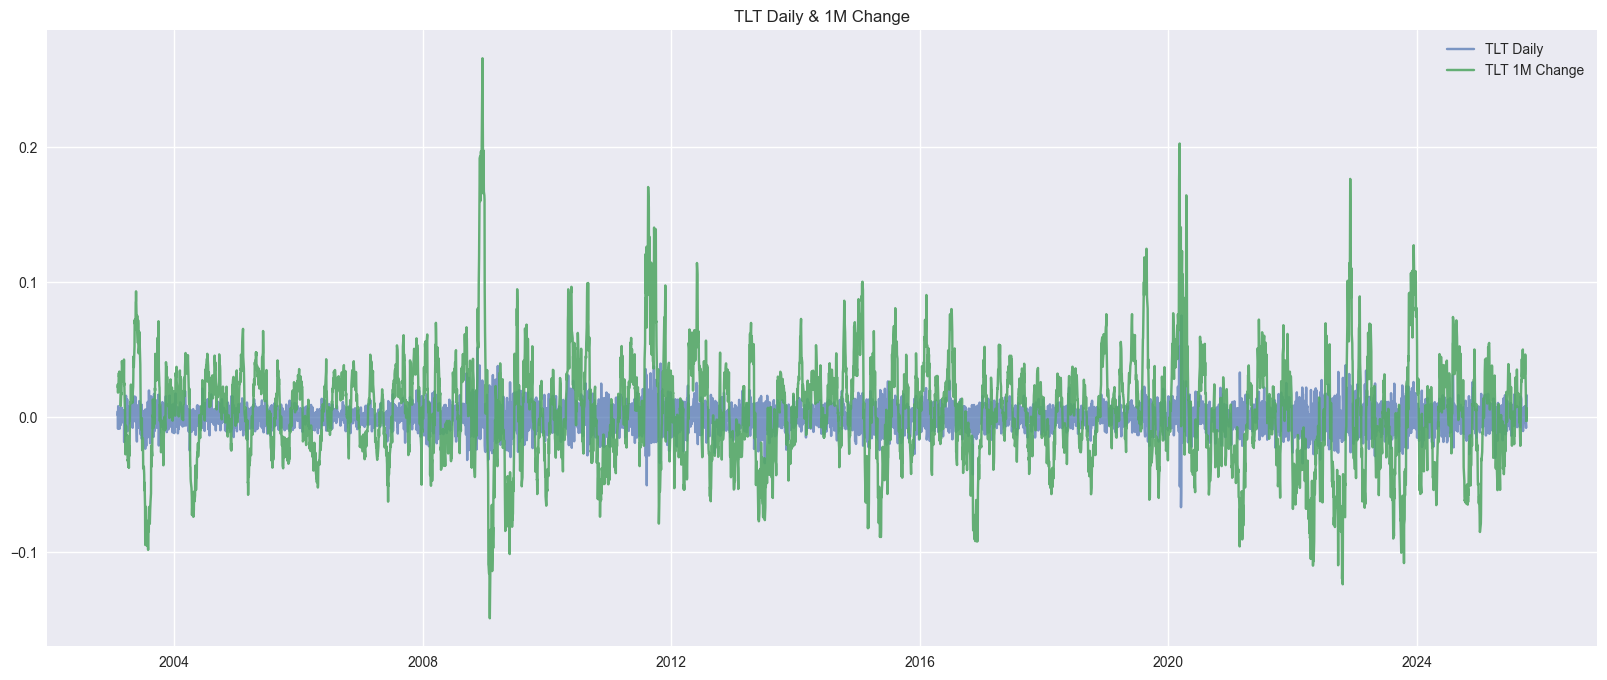

In [101]:
# Define date range
start = "2003-01-01"                           # Start date for data
end = dt.datetime.today().strftime('%Y-%m-%d') # Today

# Download TLT returns (proxy for long-term treasuries)
tlt = yf.download(SYMBOL, start=start, end=end, auto_adjust=True)['Close']
tlt[f'{SYMBOL}_ret'] = tlt[SYMBOL].pct_change()
tlt[f'{SYMBOL}_roll'] = tlt[SYMBOL].pct_change(_1_MONTH_WINDOW)
tlt.dropna(inplace=True)

# Plot the time series return data
plt.figure(figsize=(20, 8))
plt.plot(tlt[f'{SYMBOL}_ret'], alpha=0.7, label=f'{SYMBOL} Daily')
plt.plot(tlt[f'{SYMBOL}_roll'], alpha=0.9, label=f'{SYMBOL} 1M Change')
plt.title(f'{SYMBOL} Daily & 1M Change')
plt.legend()
plt.show()

As expected, the 1 month return varies more than the daily returns. The summary statistics for the 1M returns are below.

In [102]:
print(tlt[f'{SYMBOL}_roll'].describe())
print(f"Mean: {tlt[f'{SYMBOL}_roll'].mean()}")
print(f"Sdev: {tlt[f'{SYMBOL}_roll'].std()}")
print(f"Skew: {tlt[f'{SYMBOL}_roll'].skew()}")
print(f"Kurt: {tlt[f'{SYMBOL}_roll'].kurt()}")

count    5710.000000
mean        0.003679
std         0.039214
min        -0.148893
25%        -0.020803
50%         0.003916
75%         0.026859
max         0.265662
Name: TLT_roll, dtype: float64
Mean: 0.0036794975529107067
Sdev: 0.03921424543054903
Skew: 0.533119684833536
Kurt: 2.6977299040839853


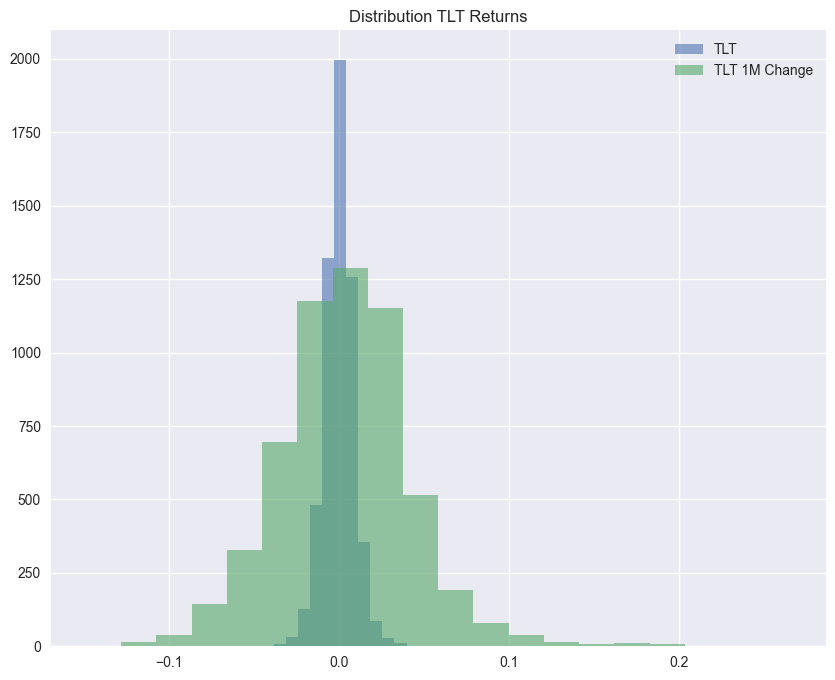

In [103]:
# Plot the distribution of TLT returns
plt.figure(figsize=(10, 8))
plt.hist(tlt[f'{SYMBOL}_ret'], bins=20, alpha=0.6, label=f'{SYMBOL}')
plt.hist(tlt[f'{SYMBOL}_roll'], bins=20, alpha=0.6, label=f'{SYMBOL} 1M Change')
plt.title(f"Distribution {SYMBOL} Returns")
plt.legend()
plt.show()

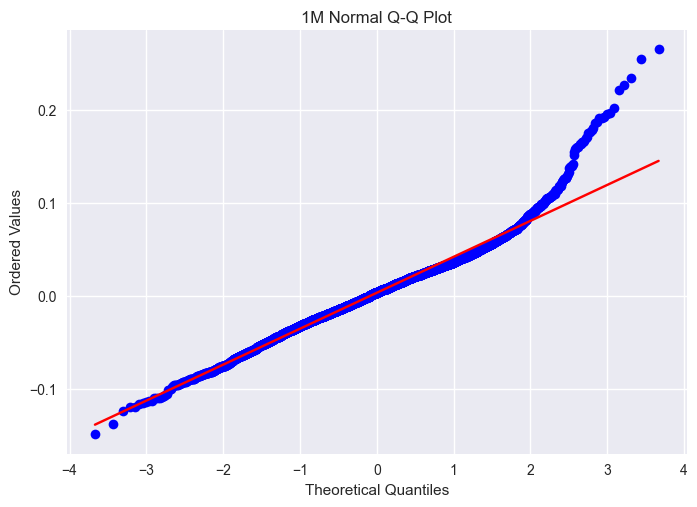

In [104]:
# Create the Q-Q plot for 1M returns
stats.probplot(tlt[f'{SYMBOL}_roll'], dist='norm', plot=plt)
plt.title('1M Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

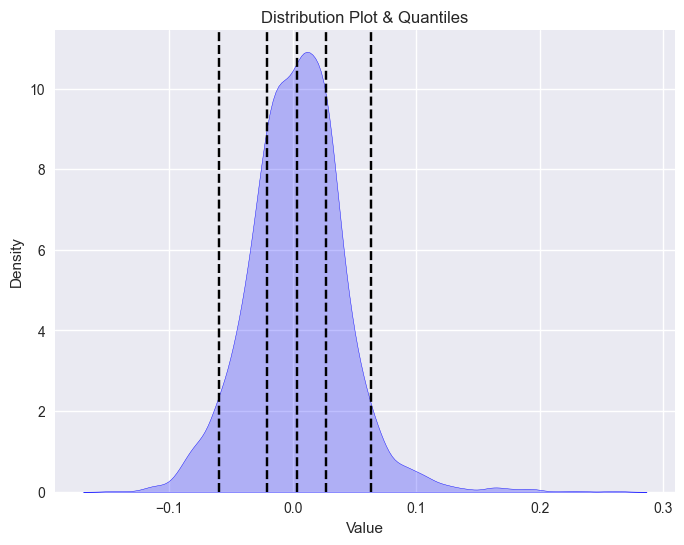

In [105]:
# Plot the quantiles and distribution
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(tlt[f'{SYMBOL}_roll'], color='blue', ax=ax, fill=True)

quantiles_to_compute = [5, 25, 50, 75, 95]
quantiles = np.percentile(tlt[f'{SYMBOL}_roll'], quantiles_to_compute)

# Add vertical lines at each quantile
for q in quantiles:
    ax.axvline(q, color='black', linestyle='--')

plt.title('Distribution Plot & Quantiles')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

From the histogram of 1M TLT returns, it appears to be an approximately normal distribution. Upon further inspection of the Q-Q plot, the data tracks closely to a normal distribution except for quantiles exceeding +2. This indicates that there is a positive skew to the distribution with an increased kurtosis. The summary statistics above show the true values of the distribution statistics. Observing the daily and monthly TLT returns, the monthly returns have wider quantiles, suggesting that the monthly data may have more regime predictability compared to the daily data. Hence the monthly data will be used to identify US bond market regimes.

## 3. Finding Features
I explore a few features that are theoretically related to long-term US bonds. The blend of features include both fundamental (macroeconomic), and technical (distrobutional/derived). The technical statistics capture the distribution of the data as it changes through time, which has fairly low time series predictability. Fundamental data on the otherhand has moderate time series predicatbility. The synergy between the fundamental and technical features may provide insights into regime classification. A summary of the fundamental features are as follows:
- DGS30 (30 year rate)
- GS10 (10 year rate)
- GS2 (2 year rate)
- T10YIE (10-year breakeven inflation rate)
- FEDFUNDS (Federal funds rate)
- CPIAUCSL (CPI for urban consumers)
- UNRATE (Unemployment rate)


In [106]:
fred_series = {
    "GS10": "10-Year Treasury Constant Maturity Rate",
    "GS2": "2-Year Treasury Constant Maturity Rate",
    "DGS30": "30-Year Treasury Constant Maturity Rate",
    "T10YIE": "10-Year Breakeven Inflation Rate",
    "FEDFUNDS": "Effective Federal Funds Rate",
    "CPIAUCSL": "Consumer Price Index for All Urban Consumers",
    "UNRATE": "Unemployment Rate"
}

# Download the macro data
macro = pd.DataFrame({s: fred.get_series(s, observation_start=start) for s in fred_series.keys()})
macro.index = pd.to_datetime(macro.index)

# Resample the data to daily
# NOTE: Some of the FRED data is only reported on a monthly basis. FFill is used to avoid lookahead bias
# NOTE: Ffill propogates the last observed value forward
macro = macro.ffill()

print(macro.head())

            GS10   GS2  DGS30  T10YIE  FEDFUNDS  CPIAUCSL  UNRATE
2003-01-01  4.05  1.74    NaN     NaN      1.24     182.6     5.8
2003-01-02  4.05  1.74   5.18    1.64      1.24     182.6     5.8
2003-01-03  4.05  1.74   5.18    1.62      1.24     182.6     5.8
2003-01-06  4.05  1.74   5.20    1.63      1.24     182.6     5.8
2003-01-07  4.05  1.74   5.18    1.62      1.24     182.6     5.8


In [107]:
# Merge TLT and macro on the date index
data = pd.merge(tlt, macro, left_index=True, right_index=True, how='inner')

In [108]:
def compute_rsi(series, window=14):
    """ Relative Strength Index """

    delta = series.diff()  # daily change
    gain = delta.clip(lower=0)  # only positive changes
    loss = -delta.clip(upper=0)  # only negative changes
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In addition to the fundamental features, I have included technical features that track the distribution of returns through time. 

In [109]:
# Yield curve spreads
data['YC_10Y_2Y'] = data['GS10'] - data['GS2']
data['YC_30Y_10Y'] = data['DGS30'] - data['GS10']

# Macro changes
data['FEDFUNDS_1m'] = data['FEDFUNDS'].pct_change(_1_MONTH_WINDOW)
data['UNRATE_1m'] = data['UNRATE'].pct_change(_1_MONTH_WINDOW)

# Momentum features
data[f'{SYMBOL}_mom_1m'] = data[f'{SYMBOL}'] / data[f'{SYMBOL}'].shift(_1_MONTH_WINDOW-1) - 1
data[f'{SYMBOL}_mom_3m'] = data[f'{SYMBOL}'] / data[f'{SYMBOL}'].shift(_3_MONTH_WINDOW-1) - 1

# Distribution features
data[f'{SYMBOL}_mean_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).mean().shift(1)
data[f'{SYMBOL}_mean_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).mean().shift(1)
data[f'{SYMBOL}_vol_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).std().shift(1)
data[f'{SYMBOL}_vol_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).std().shift(1)
data[f'{SYMBOL}_skew_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).skew().shift(1)
data[f'{SYMBOL}_skew_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).skew().shift(1)
data[f'{SYMBOL}_kurt_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).kurt().shift(1)
data[f'{SYMBOL}_kurt_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).kurt().shift(1)

# Technical features
data['RSI'] = compute_rsi(data[f'{SYMBOL}'], _1_MONTH_WINDOW).shift(1)

# Inflation momentum
data['CPI_YoY'] = data['CPIAUCSL'].pct_change(_MONTH_TO_YEAR)

# Clean data
data.dropna(inplace=True)

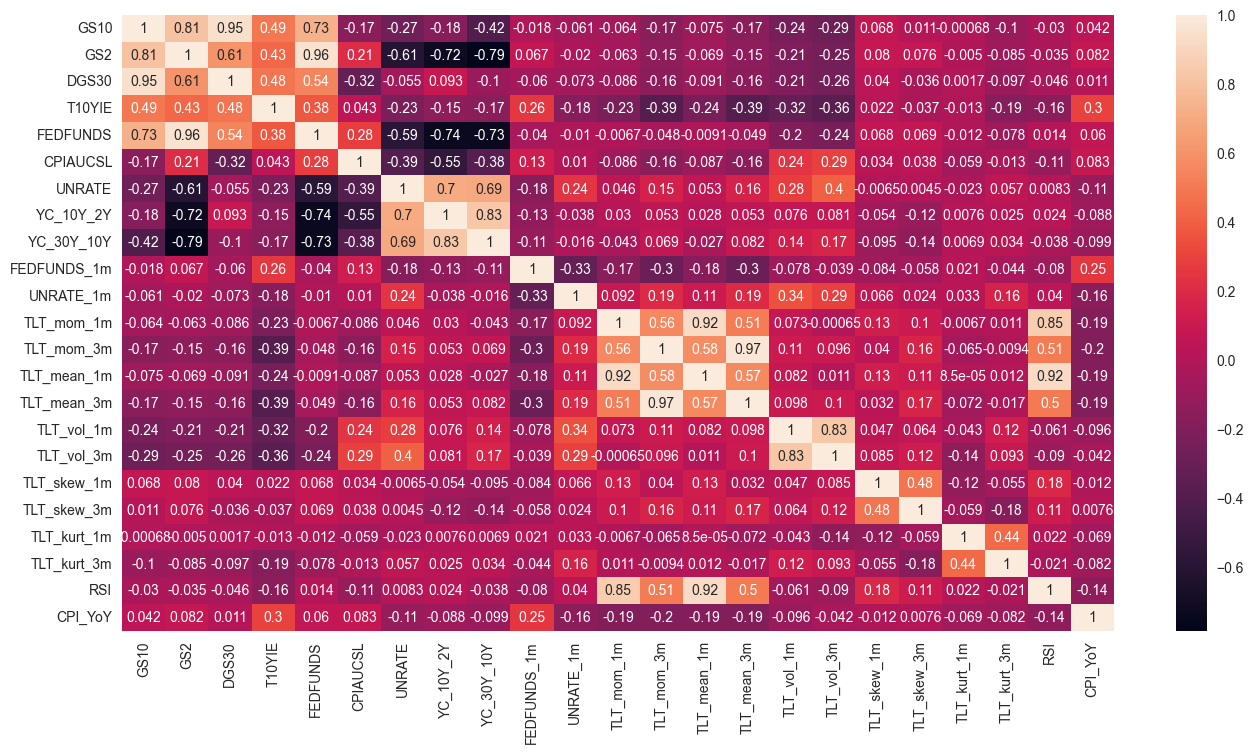

In [110]:
# Only plot the correlations of the features
NON_COLS = [f'{SYMBOL}', f'{SYMBOL}_roll', f'{SYMBOL}_ret']

feature_cols = [x for x in data.columns if x not in NON_COLS]
plt.figure(figsize=(16, 8))
sns.heatmap(data[feature_cols].corr(), annot=True)
plt.show()

As we can see, there are some strong correlations between some of the features. This means that some features capture the same signals. To reduce model overfitting, I remove correlated features.

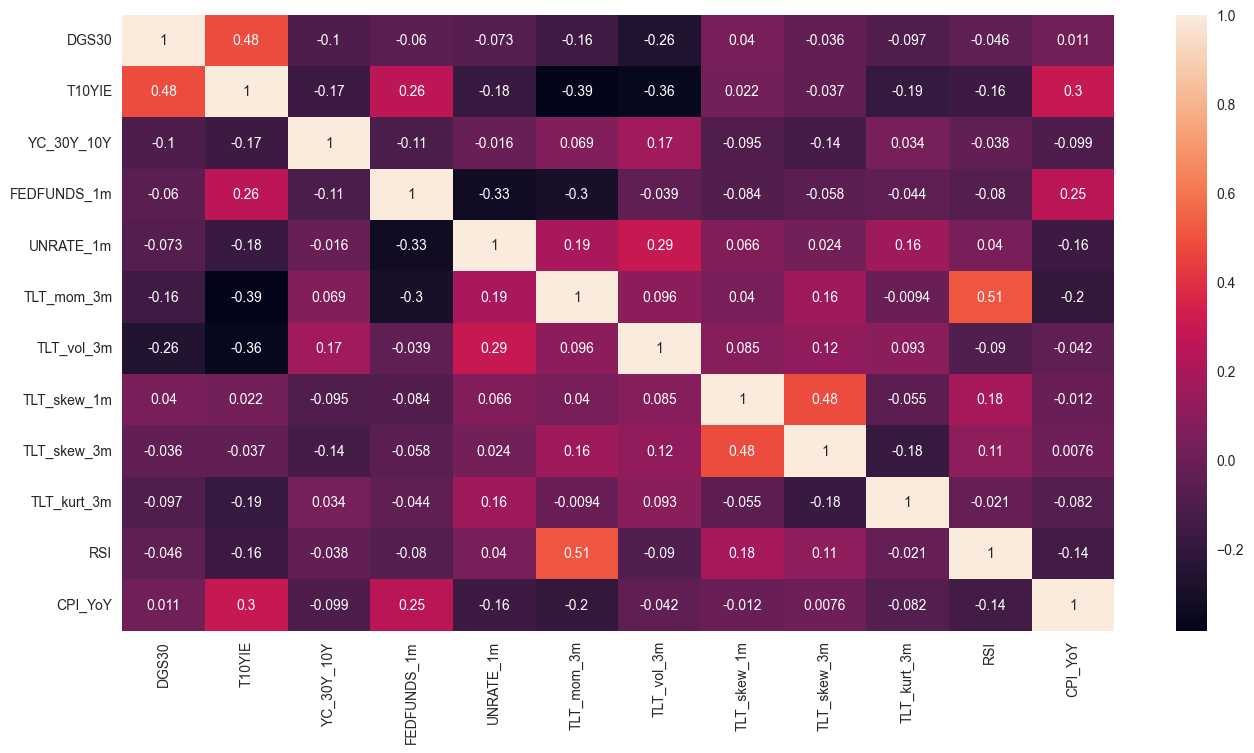

In [111]:
# Plot the feature correlation table
# NOTE: We remove highly correlated features
NON_COLS = [f'{SYMBOL}', f'{SYMBOL}_roll', f'{SYMBOL}_ret', 'GS10', 'GS2', 'YC_10Y_2Y', 'CPIAUCSL',
            'FEDFUNDS', 'UNRATE', f'{SYMBOL}_mean_1m', f'{SYMBOL}_mean_3m', f'{SYMBOL}_mom_1m', f'{SYMBOL}_vol_1m',
            f'{SYMBOL}_kurt_1m']

feature_cols = [x for x in data.columns if x not in NON_COLS]
plt.figure(figsize=(16, 8))
sns.heatmap(data[feature_cols].corr(), annot=True)
plt.show()

By removing the features that are highly correlated, the new set of features seems to caputre signals that are relativly indepenent. The highest feature correlation is between the 3M momentum and the RSI at about 0.5

## 4. Model Training
In this section, we create the regime labels, test and train data sets, and train the random forest classifier. The rules for regime identification are as follows:
- Top 40% of returns (bull regime)
- Middle 20% of returns (regime depends on the sign on the returns)
- Bottom 40% of returns (bear regime)

In [112]:
# NOTE: 80% train, 20% test for static model
split = int(len(data) * 0.8)

# Create the response and response labels
# NOTE: Value of return t+HORIZON is now at t
# NOTE: This aligns the future return with the current date
data['Future_ret_1m'] = data[f'{SYMBOL}'].pct_change(HORIZON).shift(-HORIZON)

# Define the regime
# NOTE: we are only using the training data to compute the quantiles
upper_q = data['Future_ret_1m'].iloc[:split].quantile(0.6)
lower_q = data['Future_ret_1m'].iloc[:split].quantile(0.4)
mid_q = data['Future_ret_1m'].iloc[:split].quantile(0.5)

# Top 40% of returns (long)
# Bottom 40% of returns (short)
# Middle 20% of returns (sign of future return)
data['Regime'] = 0
data.loc[data['Future_ret_1m'] > upper_q, 'Regime'] = 1

# Set the middle 20% regime
middle_mask = data['Future_ret_1m'].between(lower_q, upper_q)
data.loc[middle_mask, 'Regime'] = (data.loc[middle_mask, 'Future_ret_1m'] > 0).astype(int)

In [113]:
# Set the features and response names
features = feature_cols
response = 'Regime'

print(features)
print(response)

['DGS30', 'T10YIE', 'YC_30Y_10Y', 'FEDFUNDS_1m', 'UNRATE_1m', 'TLT_mom_3m', 'TLT_vol_3m', 'TLT_skew_1m', 'TLT_skew_3m', 'TLT_kurt_3m', 'RSI', 'CPI_YoY']
Regime


In [114]:
# Split the train and test data
X = data[features]
y = data[response]

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [115]:
random_forest = RandomForestClassifier(
    n_estimators = 500,
    max_depth = 4,
    min_samples_leaf = 0.05,
    random_state = 42,
    max_features = 'sqrt',
    oob_score = True,
)

# Fit the model to training data
random_forest.fit(X_train, y_train)

# Make test predictions
predictions = random_forest.predict(X_test)

In [116]:
# Add the predictions (next 1M to data)
data.loc[X_test.index, 'Predicted_regime'] = predictions

# Determine the strategy positions, compute returns
# NOTE: shift(1) moves the predicted regime "down" by one day, taking the previous day's prediction.
# NOTE: This ensures we are only creating a position the day after the prediction is made. (prevent look-ahead bias)
data['Position'] = data['Predicted_regime'].shift(1).apply(lambda x: 1 if x == 1 else -1)
data['Strategy_ret'] = data['Position'] * data[f'{SYMBOL}_ret']

In [117]:
strategy_df = data.loc[X_test.index].copy()

strategy_df['Strategy_cum_ret'] = (1 + strategy_df['Strategy_ret']).cumprod()
strategy_df[f'{SYMBOL}_cum_ret'] = (1 + strategy_df[f'{SYMBOL}_ret']).cumprod()

## 5. Model Performance
The section below looks at the models performance with two position sizing strategies. The first strategy is to go 100% long/short based on the predicted regime. The second strategy uses volatility scaling based on the TLT returns to scale the long or short positions.

In [118]:
# Strategy and index metrics
strategy_sharpe = (strategy_df['Strategy_ret'].mean() / strategy_df['Strategy_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)
index_sharpe = (strategy_df[f'{SYMBOL}_ret'].mean() / strategy_df[f'{SYMBOL}_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)

strategy_cagr = (strategy_df['Strategy_cum_ret'].iloc[-1]) ** (_1_YEAR_WINDOW / len(strategy_df)) - 1
index_cagr = (strategy_df[f'{SYMBOL}_cum_ret'].iloc[-1]) ** (_1_YEAR_WINDOW / len(strategy_df)) - 1

strategy_volatility = strategy_df['Strategy_ret'].std() * np.sqrt(_1_YEAR_WINDOW)
index_volatility = strategy_df[f'{SYMBOL}_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

print(f'Strategy vs {SYMBOL} Performance')
print(f'SHARPE: {strategy_sharpe:.4f} | {index_sharpe:.4f}')
print(f'CAGR:   {strategy_cagr:.4f} | {index_cagr:.4f}')
print(f'VOLATI: {strategy_volatility:.4f} | {index_volatility:.4f}')

Strategy vs TLT Performance
SHARPE: 1.7943 | -0.3003
CAGR:   0.3231 | -0.0610
VOLATI: 0.1635 | 0.1646


In [119]:
target_annual_vol = 0.10 # Volatility target

# Compute annualized strategy volatility
strategy_vol = strategy_df['Strategy_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

# Volatility scaling factor
vol_scaling = target_annual_vol / strategy_vol

# Scale positions by volatility
strategy_df['Vol_scaled_position'] = strategy_df['Position'] * vol_scaling
strategy_df['Vol_scaled_position'] = strategy_df['Vol_scaled_position'].clip(-1, 1)

# Compute the scaled returns
strategy_df['Vol_scaled_ret'] = strategy_df['Vol_scaled_position'] * strategy_df[f'{SYMBOL}_ret']
strategy_df['Vol_scaled_cum'] = (1 + strategy_df['Vol_scaled_ret']).cumprod()

# Strategy and index metrics
strategy_sharpe = (strategy_df['Vol_scaled_ret'].mean() / strategy_df['Strategy_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)
strategy_cagr = (strategy_df['Vol_scaled_cum'].iloc[-1]) ** (_1_YEAR_WINDOW / len(strategy_df)) - 1
strategy_volatility = strategy_df['Vol_scaled_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

print(f'Scaled Strategy vs {SYMBOL} Performance')
print(f'SHARPE: {strategy_sharpe:.4f} | {index_sharpe:.4f}')
print(f'CAGR:   {strategy_cagr:.4f} | {index_cagr:.4f}')
print(f'VOLATI: {strategy_volatility:.4f} | {index_volatility:.4f}')

Scaled Strategy vs TLT Performance
SHARPE: 1.0971 | -0.3003
CAGR:   0.1905 | -0.0610
VOLATI: 0.1000 | 0.1646


Both strategies significantly outperformed the TLT index (both with > 1 Sharpe ratios). This out-of-sample performance suggests that this strategy may be viable, but requires further investigation and validation. The cummulative return curves are visualized below for the out-of-sample performance.

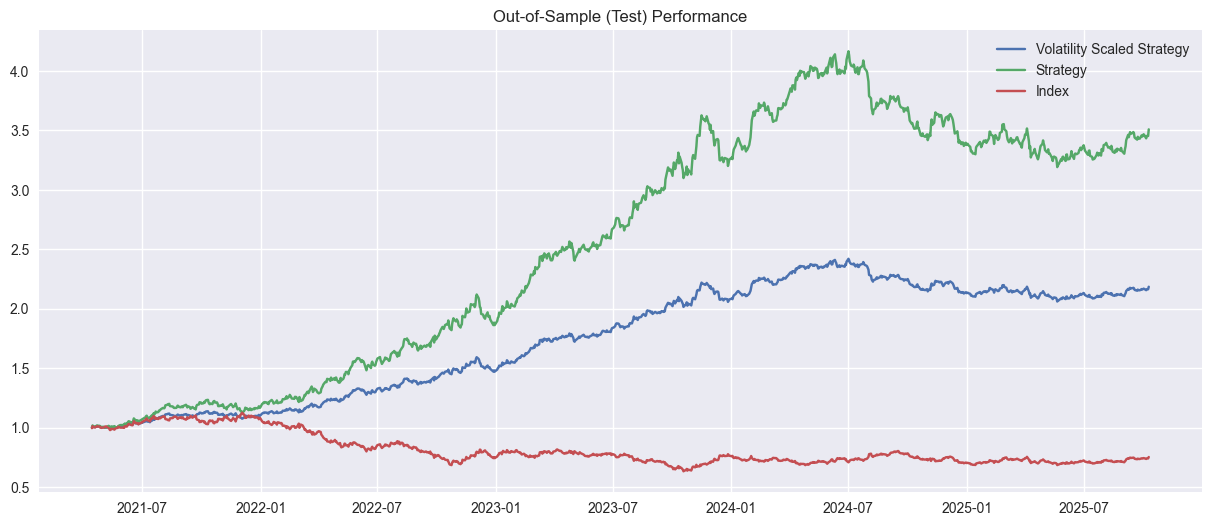

In [120]:
plt.figure(figsize=(15, 6))
plt.title('Out-of-Sample (Test) Performance')
plt.plot(strategy_df['Vol_scaled_cum'], label='Volatility Scaled Strategy')
plt.plot(strategy_df['Strategy_cum_ret'], label='Strategy')
plt.plot(strategy_df[f'{SYMBOL}_cum_ret'], label='Index')
plt.legend()
plt.show()

## 6. Model Validation
The performance looks stellar, but we must understand why the performance was so good. What was the model's prediction accuracy? How did it perform predicting bull and bear regimes? What were the most important features to the model? What was the model's accuracy if we sampled from different time periods? What was the mean squared error? What was the model's sensitivity and specificity? Was the model overfit? How sensitive is the model to parameters?

<br>
We answer these questions below.

What was the model's prediction accuracy? How did it perform predicting bull and bear regimes?

In [121]:
# Evaluate the random forest model
y_predicted = random_forest.predict(X_test)
y_probability = random_forest.predict_proba(X_test)

# Model metrics
print(f"Accuracy: {accuracy_score(y_test, y_predicted):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_predicted)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_predicted)}")

Accuracy: 0.5858
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       616
           1       0.54      0.65      0.59       514

    accuracy                           0.59      1130
   macro avg       0.59      0.59      0.59      1130
weighted avg       0.60      0.59      0.59      1130

Confusion Matrix:
[[329 287]
 [181 333]]


The model's overall accuracy was about 58%. This means the model correctly predicted around 58% of the regimes, suggesting that the model was able to capture ***some*** feature signals. The model predicted bear regimes 64% of the time and predicted bull regimes 53% of the time. The model was better at predicting bear regimes (could the model underperform in bull mearkets?). The F-1 score suggests that the model has symmetrical performance for bull and bear regimes.

What are the most important features to the model?

DGS30          0.253072
T10YIE         0.055890
YC_30Y_10Y     0.080851
FEDFUNDS_1m    0.118323
UNRATE_1m      0.053029
TLT_mom_3m     0.035933
TLT_vol_3m     0.127105
TLT_skew_1m    0.043177
TLT_skew_3m    0.019044
TLT_kurt_3m    0.083054
RSI            0.044361
CPI_YoY        0.086162
dtype: float64


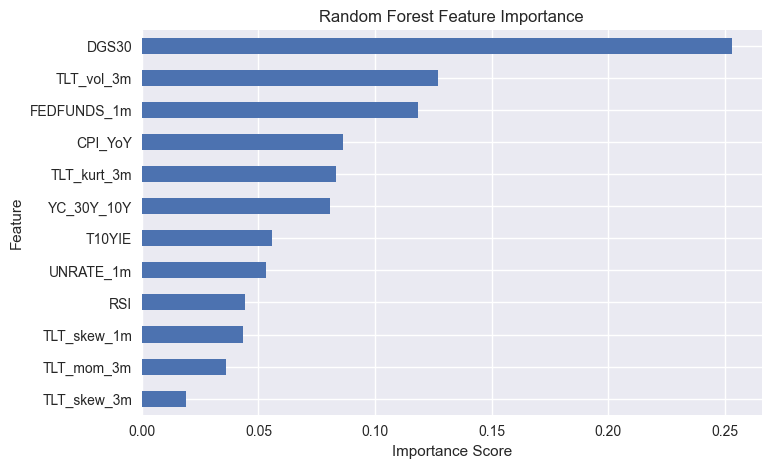

In [122]:
# Feature importance
important_features = pd.Series(random_forest.feature_importances_, index=X.columns)
print(important_features)

important_features.sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

Clearly (and intuitively), the model's most important feature was DGS30, the 30-year rate. We know that bond prices are inversly correlated with rates. This makes sense that it would be the most importand random forest feature. Other important (and still intuitive) features include the 3M volatility of returns, the 1M change in FED Funds, year-over-year change in CPI, 3M kurtosis of TLT returns, and the spread between the 30Y and 10Y rates.

What was the model's accuracy is sampled from different time periods?

In [123]:
# 10-fold cross validation
n = 10
tcsv = TimeSeriesSplit(n_splits=n)

# Accuracy for classification
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=tcsv, scoring='accuracy')

print(f'Cross-Validation Scores ({n}-fold): {cv_scores}')
print(f'CV Variation: {np.std(cv_scores)}')
print(f'Mean CV Accuracy: {np.mean(cv_scores)}')

Cross-Validation Scores (10-fold): [0.64878049 0.53902439 0.57804878 0.43170732 0.68536585 0.66097561
 0.58780488 0.54146341 0.5804878  0.50487805]
CV Variation: 0.07285664295290883
Mean CV Accuracy: 0.5758536585365854


The mean accuracy across 10 different time periods is ~0.57 (57%). This is very close to the static test set accuracy of 58%. This is a good sign of robustness as the model seems to generalize well out-of-sample. The CV variation (standard deviation) of 0.07 suggests that the model is somewhat regime dependent and indicates slight-to-moderate model instability across different market regimes. Although this is common with financial time series predictions. The model does not appear to be random with moderate predictability.

What was the mean squared error?

In [124]:
mse = mean_squared_error(y_test, y_probability[:, 1])

print(f'Test Set MSE: {mse}')

Test Set MSE: 0.24601597985531987


What was the model's sensitivity and specificity?

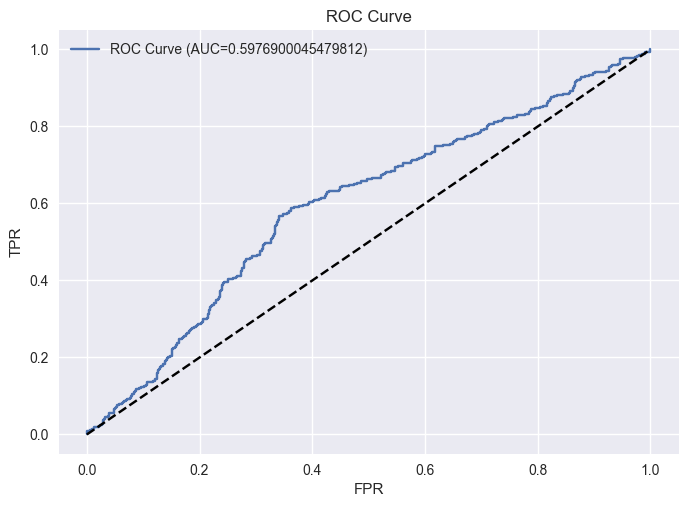

In [125]:
# fpr - false positive rate
# tpr - true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_probability[:, 1])
roc_auc = roc_auc_score(y_test, y_probability[:, 1])

plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc})')
plt.plot([0,1], [0,1], 'k--') # Diagonal
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

The ROC curve and AUC suggest that the model outperforms a random classifier (dotted line). This confirms our findings above that the model has moderate predictive power.

Was the model overfit?

In [126]:
oob_error = 1 - random_forest.oob_score_

print(f'OOB: {random_forest.oob_score_}')
print(f'OOB Error: {oob_error}')

OOB: 0.6683639583794554
OOB Error: 0.3316360416205446


In [127]:
# Get the train and test accuracy
train_acc = random_forest.score(X_train, y_train)
test_acc = random_forest.score(X_test, y_test)

print(train_acc - test_acc)

0.09802026170553335


The OOB (out-of-bag) evaluation indicates that the model learned a recognizable structure in the historical relationships of the features and response. There may be some temporal instability as the OOB is higher than the mean CV (meaning that the model ***may*** overestimate performance). The OOB and accuracy score indicate that there is no severe overfitting. 

How sensitive is the model to parameters?

,Quantile_Shift,n_estimators,max_depth,Accuracy,Precision,Recall,F1,OOB
44,0.05,500,10,0.794444,0.828054,0.666667,0.738648,0.753175
43,0.05,500,8,0.794444,0.828054,0.666667,0.738648,0.753175
28,0.00,500,8,0.794444,0.828054,0.666667,0.738648,0.753175
29,0.00,500,10,0.794444,0.828054,0.666667,0.738648,0.753175
14,-0.05,500,10,0.794444,0.828054,0.666667,0.738648,0.753175
13,-0.05,500,8,0.794444,0.828054,0.666667,0.738648,0.753175
9,-0.05,300,10,0.793651,0.824719,0.668488,0.738431,0.756349
24,0.00,300,10,0.793651,0.824719,0.668488,0.738431,0.756349
39,0.05,300,10,0.793651,0.824719,0.668488,0.738431,0.756349
8,-0.05,300,8,0.792063,0.823928,0.664845,0.735887,0.757143


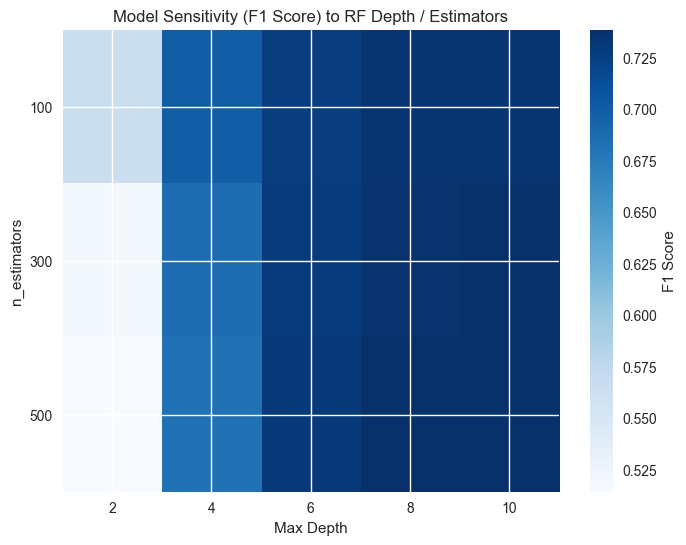

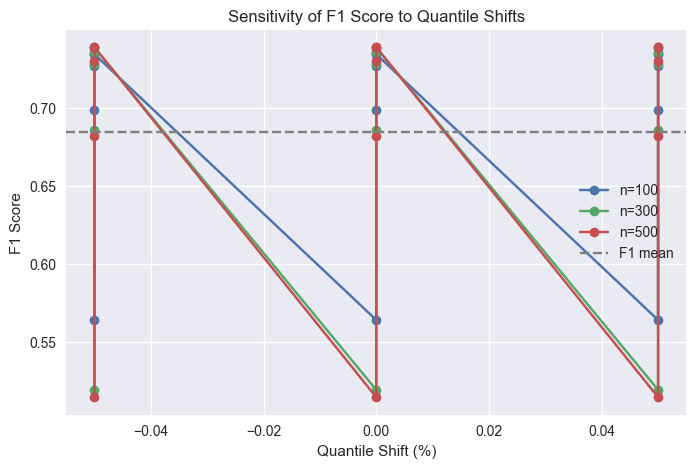

In [128]:
# Parameters to change
quantile_shifts = [-0.05, 0, 0.05]
rf_n_estimators = [100, 300, 500]
rf_depths = [2, 4, 6, 8, 10]

# Sensitivity results
sensitivity_results = []

# Create the sample window
sample_window = 5 * _1_YEAR_WINDOW
X_sample = X.iloc[-sample_window:]
y_sample = y.iloc[-sample_window:]

# Shift the quantile parameters
for q_shift in quantile_shifts:
    X_mod = X_sample.copy()

    for col in X_mod.columns:
        if 'quantile' in col.lower():
            X_mod[col] = pd.qcut(X_mod[col].rank(method='first'),
                                 q=int(10*(1+q_shift)),
                                 labels=False, duplicates='drop')

    # Shift the N estimator parameters
    for n_est in rf_n_estimators:
        for depth in rf_depths:
            rf_temp = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                max_features='sqrt',
                random_state=42,
                min_samples_leaf=0.05,
                oob_score=True
            )

            rf_temp.fit(X_mod, y_sample)
            y_pred = rf_temp.predict(X_mod)

            acc = accuracy_score(y_sample, y_pred)
            prec = precision_score(y_sample, y_pred)
            rec = recall_score(y_sample, y_pred)
            f1 = f1_score(y_sample, y_pred)

            sensitivity_results.append({
                'Quantile_Shift': q_shift,
                'n_estimators': n_est,
                'max_depth': depth,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1': f1,
                'OOB': rf_temp.oob_score_
            })

# Show the sensitivity results
sensitivity_df = pd.DataFrame(sensitivity_results)
display(sensitivity_df.sort_values('F1', ascending=False))

# Visualize the F1 sensitivity heatmap
pivot = sensitivity_df.pivot_table(index='n_estimators', columns='max_depth', values='F1', aggfunc='mean')
plt.figure(figsize=(8,6))
plt.imshow(pivot, cmap='Blues', aspect='auto')
plt.colorbar(label='F1 Score')
plt.title("Model Sensitivity (F1 Score) to RF Depth / Estimators")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("Max Depth")
plt.ylabel("n_estimators")
plt.show()

# Visualize the quantile sensitivity plot
plt.figure(figsize=(8,5))
for n_est in rf_n_estimators:
    subset = sensitivity_df[sensitivity_df['n_estimators'] == n_est]
    plt.plot(subset['Quantile_Shift'], subset['F1'], marker='o', label=f'n={n_est}')

plt.axhline(sensitivity_df['F1'].mean(), color='gray', linestyle='--', label='F1 mean')
plt.title("Sensitivity of F1 Score to Quantile Shifts")
plt.xlabel("Quantile Shift (%)")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

The model's classification boundary is stable (the predictive performance hardly changes when the quantiles are shifted by +/-5%). The model is learning from signals and not noise. The model does not overly depend on finely tuned quantile thresholds, indicating that the model generalizes well.<br>
The model performance is nearly identical for 100 and 500 trees in the random forest. This suggests that the model does not overfit with more trees. A tree depth of 6 is sufficient to capture most of the structure in the data. In real-world trading, the model indicates it would have better stability.<br>
From the F1 plot, the F1 score steadily increases with max depth and performance barely changes from 100 to 500 trees (confirmed above). This implies a smooth and stable performance across parameters. The model is well-regularized and is a low-variance ensemble.<br>
The quantile plot validates that the model is not sensitive to feature quantile thresholds.

<br>
The "fine-tuned" random forest has 300 trees with a max tree depth of 8. We will use these model parameters in the walk-forward validation (backtest). In summary, the model is robust and insensitive to changes in the model parameters.

## 7. Strategy Overview
As we see from the validation section, the model's performance and validation mostly align. This is a positive sign for the model's predictive performance. Going forward, we define the investment strategy and backtest it over the historical sample (section 8). In the next section, we backtest the two strategies outlined below:
1. Total Long/Short
- Based on the model prediction over the next month, enter a position either 100% long or 100% short.
2. Volatility Scaling
- Scale the (long/short) position from above based on the historical volatility of the index.

## 8. Backtesting

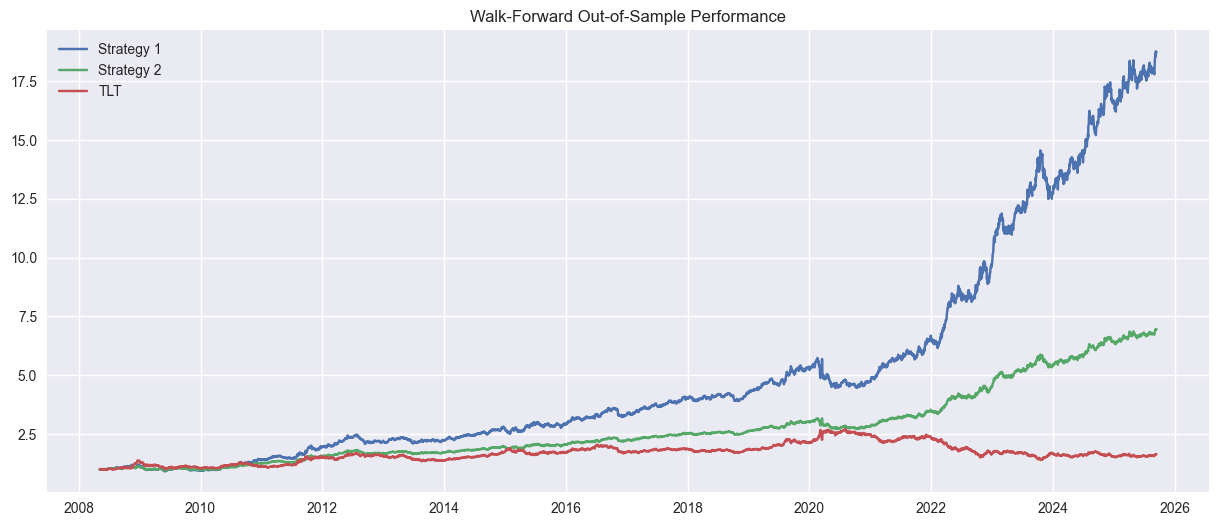

Backtest Metrics ==========
Sharpe: Strategy 1=1.1686, Strategy 2=1.1686, Index=0.2611
CAGR:   Strategy 1=0.1842, Strategy 2=0.1183, Index=0.0289
Vol:    Strategy 1=0.1550, Strategy 2=0.1000, Index=0.1554
Max Drawdown: Strategy 1=-0.2374, Strategy 2=-0.1584, Index=-0.4835
Accuracy: 0.5643
Precision: 0.5801
Recall: 0.5961
F1 Score: 0.5880
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.53      0.54      2090
           1       0.58      0.60      0.59      2278

    accuracy                           0.56      4368
   macro avg       0.56      0.56      0.56      4368
weighted avg       0.56      0.56      0.56      4368

Confusion Matrix:
 [[1107  983]
 [ 920 1358]]


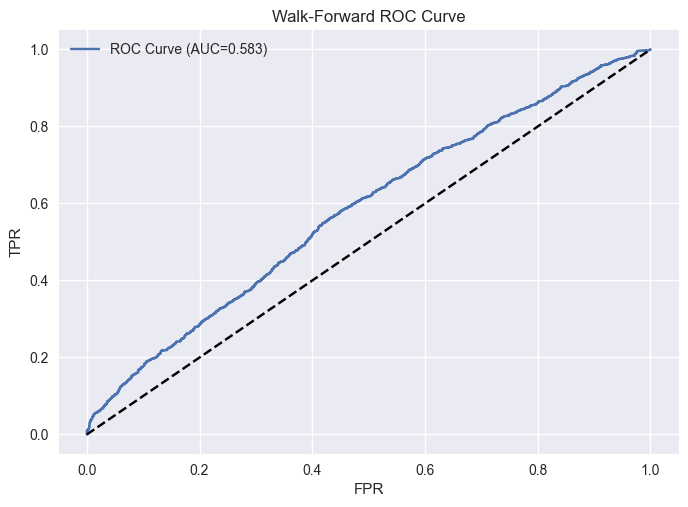

In [129]:
# Walk forward parameters
train_window = 5 * _1_YEAR_WINDOW    # 5 years of training
test_window = _1_MONTH_WINDOW        # 1 month test window

# Store results
wf_index = []
wf_actuals = []
wf_predictions = []
wf_probabilities = []

# Walk-forward (backtest) loop
for start in range(0, len(X) - train_window - test_window + 1, test_window):
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Seperate the train and test data
    # NOTE: Train data (previous 5 years)
    # NOTE: Test data (next month)
    X_train_wf = X.iloc[train_start:train_end].copy()
    X_test_wf = X.iloc[test_start:test_end].copy()

    # Identify the historical quantile thresholds
    upper_q = data['Future_ret_1m'].iloc[train_start:train_end].quantile(0.6)  # top 40% = long
    lower_q = data['Future_ret_1m'].iloc[train_start:train_end].quantile(0.4)  # bottom 40% = short

    y_train_wf_q = pd.Series(0, index=data['Future_ret_1m'].iloc[train_start:train_end].index)  # default short
    y_train_wf_q.loc[data['Future_ret_1m'].iloc[train_start:train_end] > upper_q] = 1

    # Middle quantile (based on sign of returns)
    middle_mask = data['Future_ret_1m'].iloc[train_start:train_end].between(lower_q, upper_q)
    y_train_wf_q.loc[middle_mask] = (data['Future_ret_1m'].iloc[train_start:train_end][middle_mask] > 0).astype(int)

    # True labels for test window (use original +/-0 threshold to avoid leakage)
    y_test_wf_q = (data['Future_ret_1m'].iloc[test_start:test_end] > 0).astype(int)

    # Train RF
    rf_wf = RandomForestClassifier(
        n_estimators = 300,
        max_depth = 8,
        min_samples_leaf = 0.05,
        random_state = 42,
        max_features = 'sqrt',
        oob_score = True,
    )

    # Fit model to train data
    rf_wf.fit(X_train_wf, y_train_wf_q)

    # Predict next period (1 month)
    pred_wf = rf_wf.predict(X_test_wf)
    prob_wf = rf_wf.predict_proba(X_test_wf)[:, 1]

    # Save results
    wf_index.extend(X_test_wf.index)
    wf_actuals.extend(y_test_wf_q)
    wf_predictions.extend(pred_wf)
    wf_probabilities.extend(prob_wf)

# Store results as dataframe
wf_results = pd.DataFrame({
    'Actual': wf_actuals,
    'Predicted': wf_predictions,
    'Probability': wf_probabilities
}, index=wf_index)

# Strategy 1 positions (shifted to avoid look-ahead bias) =====================================
wf_results['Position'] = wf_results['Predicted'].shift(1).map({1:1, 0:-1})
wf_results['Strategy_1_ret'] = wf_results['Position'] * data.loc[wf_results.index, f'{SYMBOL}_ret']
wf_results[f'{SYMBOL}_ret'] = data.loc[wf_results.index, f'{SYMBOL}_ret']

wf_results['Strategy_1_cum'] = (1 + wf_results['Strategy_1_ret']).cumprod()
wf_results[f'{SYMBOL}_cum'] = (1 + wf_results[f'{SYMBOL}_ret']).cumprod()

# Strategy 2 positions (shifted to avoid look-ahead bias) =====================================
target_annual_vol = 0.10 # Volatility target
strategy_vol = wf_results['Strategy_1_ret'].std() * np.sqrt(_1_YEAR_WINDOW)
vol_scaling = target_annual_vol / strategy_vol

wf_results['Vol_scaled_position'] = wf_results['Position'] * vol_scaling
wf_results['Vol_scaled_position'] = wf_results['Vol_scaled_position'].clip(-1, 1)
wf_results['Strategy_2_ret'] = wf_results['Vol_scaled_position'] * wf_results[f'{SYMBOL}_ret']
wf_results['Strategy_2_cum'] = (1 + wf_results['Strategy_2_ret']).cumprod()

# Plot backtest results
plt.figure(figsize=(15,6))
plt.plot(wf_results['Strategy_1_cum'], label='Strategy 1')
plt.plot(wf_results['Strategy_2_cum'], label='Strategy 2')
plt.plot(wf_results[f'{SYMBOL}_cum'], label=SYMBOL)
plt.title("Walk-Forward Out-of-Sample Performance")
plt.legend()
plt.show()

# Backtest metrics
def max_drawdown(cum_returns):
    rolling_max = cum_returns.cummax()
    drawdown = cum_returns / rolling_max - 1
    return drawdown.min()

# Strategy 1 metrics (and index)
sharpe_strategy_1 = (wf_results['Strategy_1_ret'].mean() / wf_results['Strategy_1_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)
sharpe_index = (wf_results[f'{SYMBOL}_ret'].mean() / wf_results[f'{SYMBOL}_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)

cagr_strategy_1 = (wf_results['Strategy_1_cum'].iloc[-1]) ** (_1_YEAR_WINDOW / len(wf_results)) - 1
cagr_index = (wf_results[f'{SYMBOL}_cum'].iloc[-1]) ** (_1_YEAR_WINDOW / len(wf_results)) - 1

vol_strategy_1 = wf_results['Strategy_1_ret'].std() * np.sqrt(_1_YEAR_WINDOW)
vol_index = wf_results[f'{SYMBOL}_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

# Strategy 2 metrics
sharpe_strategy_2 = (wf_results['Strategy_2_ret'].mean() / wf_results['Strategy_2_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)
cagr_strategy_2 = (wf_results['Strategy_2_cum'].iloc[-1]) ** (_1_YEAR_WINDOW / len(wf_results)) - 1
vol_strategy_2 = wf_results['Strategy_2_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

print("Backtest Metrics ==========")
print(f"Sharpe: Strategy 1={sharpe_strategy_1:.4f}, Strategy 2={sharpe_strategy_2:.4f}, Index={sharpe_index:.4f}")
print(f"CAGR:   Strategy 1={cagr_strategy_1:.4f}, Strategy 2={cagr_strategy_2:.4f}, Index={cagr_index:.4f}")
print(f"Vol:    Strategy 1={vol_strategy_1:.4f}, Strategy 2={vol_strategy_2:.4f}, Index={vol_index:.4f}")
print(f"Max Drawdown: Strategy 1={max_drawdown(wf_results['Strategy_1_cum']):.4f}, Strategy 2={max_drawdown(wf_results['Strategy_2_cum']):.4f}, Index={max_drawdown(wf_results[f'{SYMBOL}_cum']):.4f}")

# Backtest classification metrics
print(f"Accuracy: {accuracy_score(wf_results['Actual'], wf_results['Predicted']):.4f}")
print(f"Precision: {precision_score(wf_results['Actual'], wf_results['Predicted']):.4f}")
print(f"Recall: {recall_score(wf_results['Actual'], wf_results['Predicted']):.4f}")
print(f"F1 Score: {f1_score(wf_results['Actual'], wf_results['Predicted']):.4f}")
print("Classification Report:\n", classification_report(wf_results['Actual'], wf_results['Predicted']))
print("Confusion Matrix:\n", confusion_matrix(wf_results['Actual'], wf_results['Predicted']))

# ROC Curve
fpr, tpr, _ = roc_curve(wf_results['Actual'], wf_results['Probability'])
roc_auc = roc_auc_score(wf_results['Actual'], wf_results['Probability'])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Walk-Forward ROC Curve")
plt.legend()
plt.show()

## 9. Conclusion & Viability
From the results above, the backtest performance (validation metrics) are close to the test performance. I think this strategy is viable for real-world use. One final validation step could be live-testing in a paper account.